In [39]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.1', 'qiskit-aer': '0.8.1', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.12.2', 'qiskit-aqua': '0.9.1', 'qiskit': '0.25.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS, SGD,Adam 

from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

In [40]:
import torch
torch.cuda.is_available()

True

# Data Test 0

In [53]:
import numpy as np
from numpy import pi
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss,
                     MaxPool2d, Flatten, Sequential, ReLU)

data0Path = r'../dataset/data0test.txt'
data0Label = r'../dataset/data0testlabel.txt'

dataCoords = np.loadtxt(data0Path)
dataLabels = np.loadtxt(data0Label)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)

In [54]:

np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=60)

X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()


num_inputs=2;

feature_map = QuantumCircuit(2, name='Embed')
feature_map.rx(pi*Parameter('x[0]'),0)
feature_map.rx(pi*Parameter('x[1]'),1)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)

param_y=[];
for i in range(5):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(2, name='PQC')
for i in range(2):
    ansatz.rx(param_y[i],i)
for i in range(2):
    ansatz.rz(param_y[i+2],i)
ansatz.crx(param_y[4],1,0)



qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);


41.355628967285156
34.73762512207031
28.43988800048828
26.591997146606445
26.20227813720703
26.127466201782227
26.09093475341797
26.20258331298828
25.805492401123047
25.489187240600586
44.570762634277344
52.83230972290039
53.89324188232422
36.02682113647461
62.769012451171875
53.54864501953125
41.90972900390625
38.811431884765625
31.93553352355957
63.6278190612793


Accuracy: 0.9833333333333333


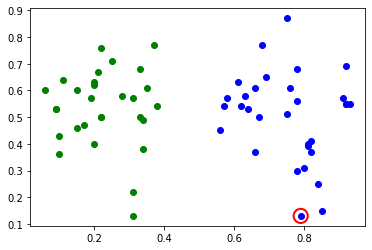

In [55]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

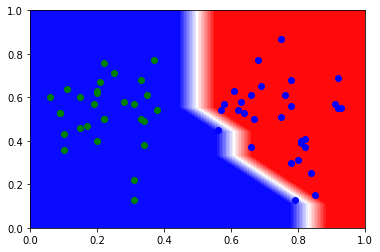

In [56]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=10)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

# Data 1a

In [57]:
data1aPath = r'../dataset/data1a.txt'
data1aLabel = r'../dataset/data1alabel.txt'

dataCoords = np.loadtxt(data1aPath)
dataLabels = np.loadtxt(data1aLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)

np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=60)

X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()


num_inputs=2;

feature_map = QuantumCircuit(2, name='Embed')
feature_map.rx(pi*Parameter('x[0]'),0)
feature_map.rx(pi*Parameter('x[1]'),1)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)


param_y=[];
for i in range(5):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(2, name='PQC')
for i in range(2):
    ansatz.rx(param_y[i],i)
for i in range(2):
    ansatz.rz(param_y[i+2],i)
ansatz.crx(param_y[4],1,0)


qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

41.29439926147461
36.08946228027344
31.56851577758789
29.729461669921875
29.444931030273438
29.37013053894043
29.31624984741211
43.10381317138672
29.627605438232422
52.4751091003418
49.05715560913086
41.73005294799805
38.550785064697266
45.518707275390625
33.850921630859375
45.08257293701172
51.972312927246094
31.717708587646484
41.49787521362305
58.4487190246582


Accuracy: 0.7333333333333333


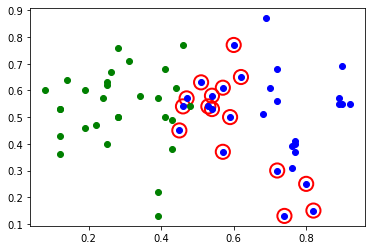

In [58]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

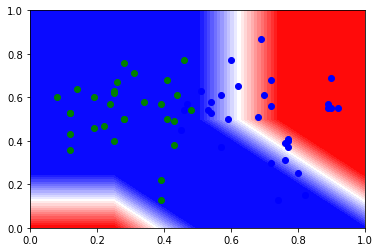

In [59]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=5)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

# Data 1b

In [60]:
data1bPath = r'../dataset/data1b.txt'
data1bLabel = r'../dataset/data1blabel.txt'

dataCoords = np.loadtxt(data1bPath)
dataLabels = np.loadtxt(data1bLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)


np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=60)

X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()


num_inputs=2;

feature_map = QuantumCircuit(2, name='Embed')
feature_map.rx(pi*Parameter('x[0]'),0)
feature_map.rx(pi*Parameter('x[1]'),1)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)


param_y=[];
for i in range(5):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(2, name='PQC')
for i in range(2):
    ansatz.rx(param_y[i],i)
for i in range(2):
    ansatz.rz(param_y[i+2],i)
ansatz.crx(param_y[4],1,0)



qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

41.558597564697266
39.454071044921875
40.357200622558594
36.151519775390625
35.99721145629883
35.14678192138672
34.951416015625
34.99629592895508
34.69892883300781
34.64987564086914
34.62653350830078
34.61245346069336
34.60893249511719
34.608890533447266
34.608890533447266


Accuracy: 0.7833333333333333


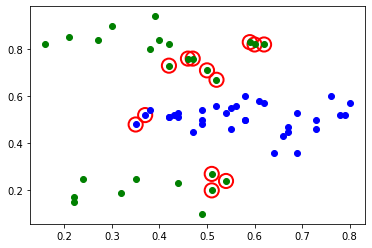

In [61]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

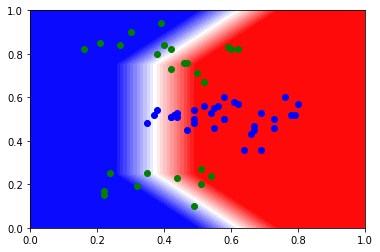

In [62]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=5)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

# Data 1c

In [63]:
data1aPath = r'../dataset/data1c.txt'
data1aLabel = r'../dataset/data1clabel.txt'

dataCoords = np.loadtxt(data1aPath)
dataLabels = np.loadtxt(data1aLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)


np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=60)

X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()


num_inputs=2;

feature_map = QuantumCircuit(2, name='Embed')
feature_map.rx(pi*Parameter('x[0]'),0)
feature_map.rx(pi*Parameter('x[1]'),1)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)


param_y=[];
for i in range(5):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(2, name='PQC')
for i in range(2):
    ansatz.rx(param_y[i],i)
for i in range(2):
    ansatz.rz(param_y[i+2],i)
ansatz.crx(param_y[4],1,0)



qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

41.76023864746094
36.34159469604492
30.89705467224121
28.327688217163086
28.0992431640625
28.055953979492188
27.950485229492188
27.867359161376953
27.755136489868164
27.667490005493164
27.458723068237305
27.394554138183594
27.238481521606445
27.18937110900879
27.150033950805664
27.145641326904297
27.144439697265625
27.144433975219727
27.144437789916992
27.144433975219727


Accuracy: 0.9666666666666667


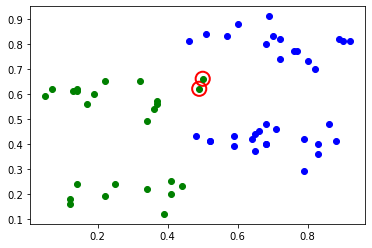

In [64]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

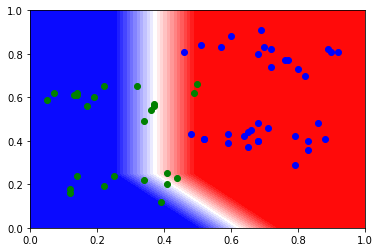

In [65]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=5)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

# Data 2a

In [66]:
data1aPath = r'../dataset/data2a.txt'
data1aLabel = r'../dataset/data2alabel.txt'

dataCoords = np.loadtxt(data1aPath)
dataLabels = np.loadtxt(data1aLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)


np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=60)

X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()


num_inputs=2;

feature_map = QuantumCircuit(2, name='Embed')
feature_map.rx(pi*Parameter('x[0]'),0)
feature_map.rx(pi*Parameter('x[1]'),1)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)


param_y=[];
for i in range(5):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(2, name='PQC')
for i in range(2):
    ansatz.rx(param_y[i],i)
for i in range(2):
    ansatz.rz(param_y[i+2],i)
ansatz.crx(param_y[4],1,0)



qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

35.37158966064453
32.50820541381836
32.22746276855469
32.192413330078125
32.180912017822266
32.17634582519531
32.165836334228516
32.141212463378906
32.08496856689453
31.96446418762207
31.742942810058594
31.44750213623047
45.42028045654297
49.74735641479492
42.161067962646484
43.50112533569336
34.2496452331543
39.310882568359375
37.87492370605469
36.90576934814453


Accuracy: 0.7833333333333333


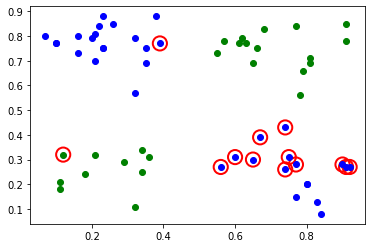

In [67]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

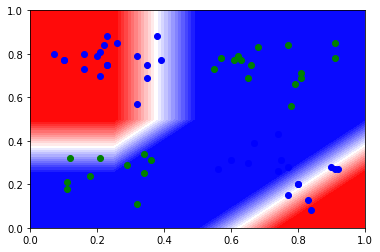

In [68]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=5)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

# Data 2b

In [69]:
data1aPath = r'../dataset/data2b.txt'
data1aLabel = r'../dataset/data2blabel.txt'

dataCoords = np.loadtxt(data1aPath)
dataLabels = np.loadtxt(data1aLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)


np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=60)

X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()


num_inputs=2;

feature_map = QuantumCircuit(2, name='Embed')
feature_map.rx(pi*Parameter('x[0]'),0)
feature_map.rx(pi*Parameter('x[1]'),1)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)


param_y=[];
for i in range(5):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(2, name='PQC')
for i in range(2):
    ansatz.rx(param_y[i],i)
for i in range(2):
    ansatz.rz(param_y[i+2],i)
ansatz.crx(param_y[4],1,0)



qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

42.7203369140625
40.344032287597656
41.1057243347168
39.42128372192383
39.36815643310547
39.32874298095703
39.2984504699707
39.30898666381836
39.28617477416992
39.283809661865234
39.283321380615234
39.28330993652344
39.28330993652344


Accuracy: 0.5


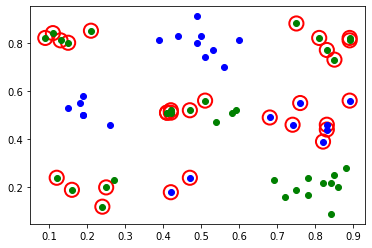

In [70]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

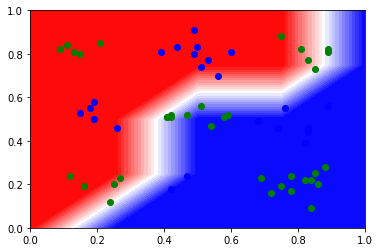

In [71]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=5)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

# Data 2c

In [72]:
data1aPath = r'../dataset/data2c.txt'
data1aLabel = r'../dataset/data2clabel.txt'

dataCoords = np.loadtxt(data1aPath)
dataLabels = np.loadtxt(data1aLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)

np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=60)

X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()


num_inputs=2;

feature_map = QuantumCircuit(2, name='Embed')
feature_map.rx(pi*Parameter('x[0]'),0)
feature_map.rx(pi*Parameter('x[1]'),1)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)


param_y=[];
for i in range(5):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(2, name='PQC')
for i in range(2):
    ansatz.rx(param_y[i],i)
for i in range(2):
    ansatz.rz(param_y[i+2],i)
ansatz.crx(param_y[4],1,0)



qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

42.510555267333984
41.565765380859375
41.71660614013672
40.740943908691406
40.68627166748047
40.606903076171875
40.58984375
40.577816009521484
40.570716857910156
40.56510543823242
40.558326721191406
40.556312561035156
40.55522537231445
40.55500793457031
40.55491638183594
40.554908752441406
40.554901123046875
40.554901123046875


Accuracy: 0.6


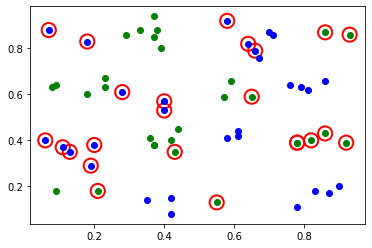

In [73]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

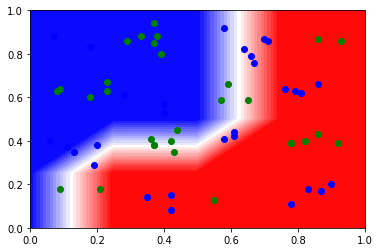

In [74]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=5)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

# Data 3a

In [75]:
data1aPath = r'../dataset/data3a.txt'
data1aLabel = r'../dataset/data3alabel.txt'

dataCoords = np.loadtxt(data1aPath)
dataLabels = np.loadtxt(data1aLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)


np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=60)

X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()


num_inputs=2;

feature_map = QuantumCircuit(2, name='Embed')
feature_map.rx(pi*Parameter('x[0]'),0)
feature_map.rx(pi*Parameter('x[1]'),1)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)

param_y=[];
for i in range(5):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(2, name='PQC')
for i in range(2):
    ansatz.rx(param_y[i],i)
for i in range(2):
    ansatz.rz(param_y[i+2],i)
ansatz.crx(param_y[4],1,0)



qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

43.44672393798828
41.768943786621094
45.57057571411133
38.57276153564453
43.87662887573242
37.652008056640625
37.4957160949707
37.510887145996094
37.41633987426758
37.4077262878418
37.38167953491211
37.34990692138672
37.33110046386719
37.304569244384766
37.29042053222656
37.2749137878418
37.27446746826172
37.273170471191406
37.27317428588867
37.27317810058594


Accuracy: 0.7


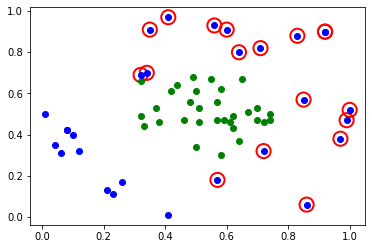

In [76]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

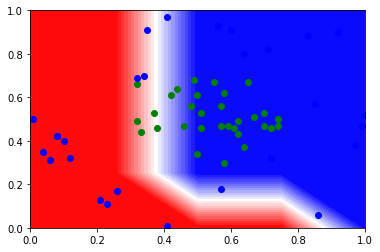

In [77]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=5)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

# Data 3b

In [78]:
data1aPath = r'../dataset/data3b.txt'
data1aLabel = r'../dataset/data3blabel.txt'

dataCoords = np.loadtxt(data1aPath)
dataLabels = np.loadtxt(data1aLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)


np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=60)

X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()


num_inputs=2;

feature_map = QuantumCircuit(2, name='Embed')
feature_map.rx(pi*Parameter('x[0]'),0)
feature_map.rx(pi*Parameter('x[1]'),1)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)


param_y=[];
for i in range(5):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(2, name='PQC')
for i in range(2):
    ansatz.rx(param_y[i],i)
for i in range(2):
    ansatz.rz(param_y[i+2],i)
ansatz.crx(param_y[4],1,0)



qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

39.2502555847168
38.73743438720703
38.62435531616211
38.56282424926758
38.50373077392578
38.48065948486328
38.46812438964844
38.456600189208984
38.44728469848633
38.44003677368164
38.43792724609375
38.43675231933594
38.4363899230957
38.436344146728516
38.43632888793945
38.43632507324219
38.43632125854492


Accuracy: 0.65


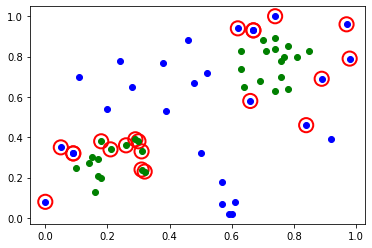

In [79]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

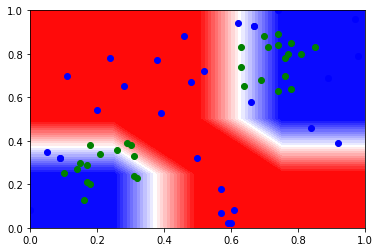

In [80]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=5)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

# Data 3c

In [81]:
data1aPath = r'../dataset/data3c.txt'
data1aLabel = r'../dataset/data3clabel.txt'

dataCoords = np.loadtxt(data1aPath)
dataLabels = np.loadtxt(data1aLabel)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)


np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=60)

X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()


num_inputs=2;

feature_map = QuantumCircuit(2, name='Embed')
feature_map.rx(pi*Parameter('x[0]'),0)
feature_map.rx(pi*Parameter('x[1]'),1)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)


param_y=[];
for i in range(5):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(2, name='PQC')
for i in range(2):
    ansatz.rx(param_y[i],i)
for i in range(2):
    ansatz.rz(param_y[i+2],i)
ansatz.crx(param_y[4],1,0)



qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad()                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

42.44318389892578
40.753875732421875
39.78712463378906
39.68467712402344
39.66823959350586
39.66682052612305
39.666316986083984
39.66629409790039
39.66612243652344
39.666019439697266
39.665889739990234
39.66587448120117
39.66586685180664
39.665870666503906


Accuracy: 0.6666666666666666


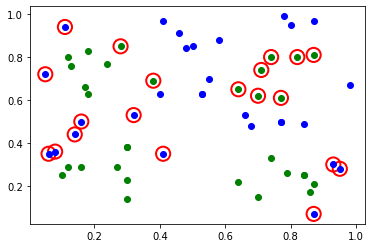

In [82]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

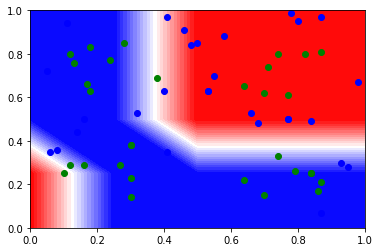

In [83]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=5)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)